### Tutorial

Before aligning any fancy models and with larger datasets, we will first go through a step-by-step tutorial about finding some concrete alignments in a small transformer model for a specific simple program. The goal of this tutorial is to help us to really visualize and verify alignments found using our method.

For the process of how to come up this dataset, you can refer to `datasets_visualizations.ipynb`

In [1]:
from utils import *

set_seed(SEED)
logging.set_verbosity(logging.ERROR)

/opt/conda/envs/wuzhengx-bootleg/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### We we are aligning after all?

Here, we will create a toy dataset that has an intuitive solution with a clear high-level causal graph.

In [2]:
# let's load a program from the disk.
programs = json.load(open("seed_programs.json"))
program = ("07065a", programs["07065a"])

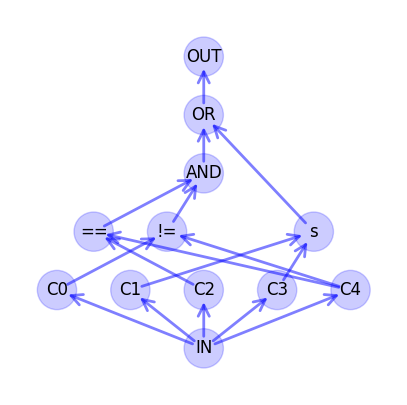

In [3]:
# you can also visualize your program.
visualize_program(program[1])

In [4]:
program[0] # this is the program unique id!

'07065a'

This is the causal graph that we will use to generate our training data. As you can see, it involves multi-step reasonings over input words. We want to see **if a neural network** that is trained to solve this task actually follows this reasoning graph! If it does, it is amazing right? It means, through learning data patterns, the model is able to compress information in a structural and meaningful way as a human!

#### Creating our training data.

We will make this dataset as a seq2seq dataset, where inputs contain 5 words, and the ouputs contain 1 word. This setup allows us to extend the experiment to much larger decoder-only later on. Additionally, the LM head is nothing but a classifier which has more classes.

##### Tokenize your dataset.

Instead of raw words with a space tokenizer, we use the real gpt-2 tokenizer where words can be shattered into multiple tokens. This is, in fact, really interesting in terms of interpretability, and we will see why!

And everything here is pretty standard HF preprocessing pipeline, so if you are familar with these, please skip!

In [5]:
tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token
n_training_examples = 22000
data_module = make_supervised_data_module(
    program, 
    n_training_examples,
    tokenizer
)
train_dataset = data_module["train_dataset"]
validation_dataset = data_module["eval_dataset"]
test_dataset = data_module["test_dataset"]

seq_lens = [len(e["input_ids"]) for e in train_dataset]
Counter(seq_lens)

Counter({12: 20000})

In [6]:
print(train_dataset[0])

{'question': 'else,sup,Else,udging,Else', 'answers': True, 'input_ids': [17772, 11, 37330, 11, 40674, 11, 38840, 11, 40674, 28, 17821, 50256], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'labels': [-100, -100, -100, -100, -100, -100, -100, -100, -100, -100, 17821, 50256]}


Let's take a look at our dataset before we train any model to make sure we are not doing something incorrectly. You can also see that our trigger word is with index `28`! and our output is a single token as well in this case with a token id `17821`. The last token is a constant stop token, so we don't have to worry about that. `-100` means that token will be taken out when calculating the loss.

<Axes: >

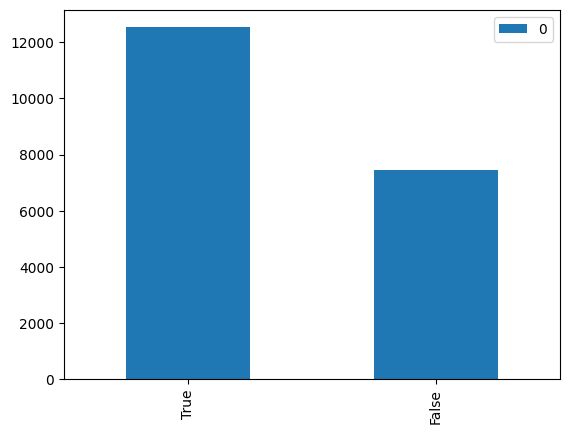

In [7]:
count = Counter(train_dataset["answers"])
df = pd.DataFrame.from_dict(count, orient='index')
df.plot(kind='bar')

#### Setup our training pipeline!

We then need to setup a small gpt2 model (we need to use a pretrained one since we have semantic relations as well!) along with other stuffs that are needed to train our model to overfit to this little logical problem! Again, we try to have a minimal code here, and rely on the HF library to train the model.

In [8]:
model_name_or_path = "./tutorial_results/checkpoint-200/"

lazy_interval = 200
training_args = TrainingArguments(
    num_train_epochs=35, # this ensures ovefitting! but overfitting is interesting to analyze!
    logging_steps=lazy_interval,
    evaluation_strategy="steps",
    eval_steps=lazy_interval,
    learning_rate=4e-5, # you can be aggressive here!
    weight_decay=0.01,
    lr_scheduler_type="cosine",
    per_device_train_batch_size=128,
    per_device_eval_batch_size=128,
    output_dir="./tutorial_results",
    save_strategy="steps",
    save_steps=lazy_interval,
    seed=SEED,
    load_best_model_at_end=True,
    report_to="none"
)
if model_name_or_path is None:
    model = GPT2LMHeadModel.from_pretrained(
        "gpt2",
        cache_dir="./.cache_dir/"
    )
    data_collator = DataCollatorForSeq2Seq(
        tokenizer,
        model=model,
        label_pad_token_id=IGNORE_INDEX,
        padding="longest"
    )
    print("Number of parameters:", model.num_parameters())
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=validation_dataset,
        data_collator=data_collator,
    )
    trainer.train()
else:
    model = GPT2LMHeadModel.from_pretrained(
        model_name_or_path,
        cache_dir="./.cache_dir/"
    )

#### Evaluation in terms of accuracy.

Starting from here, we actually want to as explicit as possible, instead of relying on HF stuffs since we want to percisely interpret what the model is doing!

In [9]:
tokenizer = AutoTokenizer.from_pretrained(
    "gpt2",
    padding_side='left',
    use_fast=False
)
tokenizer.pad_token = tokenizer.eos_token
clm_new_token_trigger = "="
_ = model.eval()
with torch.no_grad():
    preds = []
    for batch_example in tqdm(chunk(
        test_dataset, training_args.per_device_eval_batch_size*training_args.n_gpu
    )):
        actual_batch = []
        for i, example in enumerate(batch_example):
            prompt = example['question'] + f"{clm_new_token_trigger}"
            if isinstance(prompt, str):
                in_text = prompt
            else:
                raise TypeError(f"Unrecognized type for example input: {type(prompt)}")
            actual_batch.append(in_text)
        # tokenize and then pass them to the model.
        tokenized = tokenizer(actual_batch, return_tensors='pt', padding=True)
        tokenized = {
            k: v.to(model.device) if isinstance(v, torch.Tensor) else v 
            for k, v in tokenized.items()
        }
        outputs = model.generate(
            **tokenized,
            eos_token_id=tokenizer.eos_token_id,
            max_new_tokens=1, # ha, i am not sure what makes sense here actually.
            early_stopping=True,
        )
        actual_preds = tokenizer.batch_decode(outputs, skip_special_tokens=True)
        preds.extend([{'prompt': in_text, 'prediction': extract_output(pred, clm_new_token_trigger),
                       'answers': example['answers']}
                      for in_text, pred, example in zip(actual_batch, actual_preds, batch_example)])
num_correct = 0.
for p in preds:
    if p['prediction'] == str(p['answers']):
        num_correct += 1
num_correct /= len(preds)
print("accuracy:", round(num_correct, 4))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.58s/it]

accuracy: 0.975


In [10]:
assert num_correct > 0.95

#### Individual causal variable alignment search.

Now that we have a good model that solves this test set, we can then analyze whether this model actually realize some causal internals through our training process. Let's first target one variable at a time. Let's target the first equality operator!

**For this particular example**, the first operator connects `C2` and `C4`. To align this variable with our neural network's representations, we use boundless DAS. After alignment training, we basically want to see if *counterfactually* a group of neurons behave the same way as our high-level causal model shown below mediated by this aligning variable! After you find a good alignment, you can basically perturb this variable at inference time to let the model do whatever you want in a controllable way.

**Notation:** To make life easier, we now label causal variables as 0 - 4 representing {0, 1, 2, 3, 4} hidden causal variables on this graph. Note that we now are excluding `C*` input concept variables for simplicity. And in this case, we are aligning variable 0.

In [11]:
program[1]

[[[1, 3], 's', [2, 4, 0], ['==', '!=']], [[5, 6], 'AND'], [7, 'OR']]

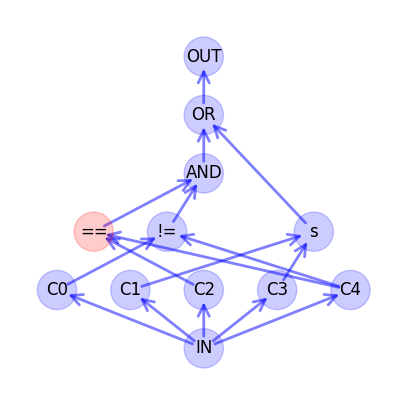

In [12]:
# you can also visualize your program with the node you are intervening on in red.
visualize_program(program[1], intervene_on=5)

To create alignment dataset, we need to have counterfactual pairs `(base example, source example)` and these two examples can have different or same value on the variable 0. We then going to swap the variable 0 values between these two examples, and produce a counterfactual output.

To start, let's use the same sampling function above which we used to train our gpt2 model.

In [13]:
all_vocab, synonyms_pairs, synonyms_dict = fetch_metadata(".", use_token=True)
_, base_inputs, _, base_value_maps = sample_factual_inputs(
    program[1], all_vocab, synonyms_pairs, synonyms_dict
)
base_value_maps

{'op1': True, 'op2': True, 'op3': False, 'op4': True, 'op5': True}

In [14]:
_, source_inputs, _, source_value_maps = sample_factual_inputs(
    program[1], all_vocab, synonyms_pairs, synonyms_dict
)
source_value_maps

{'op1': True, 'op2': True, 'op3': False, 'op4': True, 'op5': True}

The above value maps show the value on different causal variables. We interchange on `op1` which maps to the equality check here. Let's write a very simple function that can derive the counterfactual output for us, taking in two value maps as well as the program itself.

In [15]:
base_value_maps = {'op1': True, 'op2': True, 'op3': False, 'op4': True, 'op5': True}
source_value_maps = {'op1': False, 'op2': True, 'op3': False, 'op4': False, 'op5': False}
fetch_counterfactual_value(base_value_maps, source_value_maps, program[1], "op1", "op5")

False

Now, we are ready to generate a bunch of training tuples using this function! Basically, what we want for aligning this single causal variable is 

`(base example, source example, variable, base pos, source pos, counterfactual output)`

Note that `(base pos, source pos)` is the new information bits we added in for this task. In the Alpaca task the testing input is with fixed length, so you can just specify this in the DAS config instead. By specifying this, we allow cross position interventions in the neural network on-the-fly. **This also allows exponentially large intervention choices. Thus, we recommend you start with something sensible first, and see if you can find an alignment.**

Here, we intervene on the same token since our inputs are constructed using tokens, not words. We left this flexibility for future research.

In [16]:
"""
WARNING: this is some heuristic stuff that we
assume we are looking for alignments on the token
representation beam on top of the second word 
participated in the process of deriving the
value of our targeted causal variable.

UPDATE: if we are using token-based data generation,
then your token position should be fixed.
"""
target_word_beam = max(program[1][0][2][:2])
token_position_strategy = "last_of_beam"
print("target word position index in the sentence:", target_word_beam)

target word position index in the sentence: 4


For instance, given an input tokenized like this,

`[appl, ##e, taste, ##s, very, very, deli, ##cious, to, me]`

the word beam for the fifth word is

`[deli, ##cious]`

So, we search the representation of that causal variable within this beam.

In [82]:
n_alignment_training_examples = 22000
counterfactual_data_module = make_supervised_counterfactual_data_module(
    program,
    "op1",
    n_alignment_training_examples,
    target_word_beam, 
    [8, 9],
    tokenizer
)
train_cdataset = counterfactual_data_module["train_dataset"]
validation_cdataset = counterfactual_data_module["eval_dataset"]
test_cdataset = counterfactual_data_module["test_dataset"]
print(train_cdataset[0])

{'intervention_ids': 0, 'input_ids': [23795, 11, 48997, 11, 23795, 11, 39752, 11, 23795, 28, 17821], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'source_input_ids': [11531, 11, 22614, 11, 20541, 11, 44623, 11, 20541, 28, 17821], 'source_attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'labels': [-100, -100, -100, -100, -100, -100, -100, -100, -100, -100, 17821], 'token_range': [8, 9], 'source_token_range': [8, 9]}


**WARNING:** There are a couple of places we can do intervention (and they do not form an exhaustive list). We can intervene starting position 8, but we can also do 9, 10.

In [18]:
# verify sequence length, intervention postion index, etc..
for e in train_cdataset:
    assert len(e["input_ids"]) == len(e["source_input_ids"])
    assert len(e["input_ids"]) == 11
    assert e["token_range"][0] == 8
    assert e["token_range"][1] == 9
    assert e["source_token_range"][0] == 8
    assert e["source_token_range"][1] == 9

#### Aligning with the residual stream.

There are multiple places where we can do the alignment. In this tutorial, we are aligning the residual steam in each layer.

**Note:** the previous repo actually does not work with this setting since we added in dynamic token range for alignment right now.

In [20]:
#########################################
# DO NOT RUN UNLESS YOU READ LINES ABOVE
# !cp ../../torch3.8_overwrite/init.py /opt/conda/envs/wuzhengx-bootleg/lib/python3.9/site-packages/torch/nn/
# !cp ../../torch3.8_overwrite/parametrizations.py /opt/conda/envs/wuzhengx-bootleg/lib/python3.9/site-packages/torch/nn/utils/
#########################################

In [21]:
# You can define your custom compute_metrics function.
def compute_metrics(eval_preds, eval_labels):
    total_count = 0
    correct_count = 0
    for eval_pred, eval_label in zip(eval_preds, eval_labels):
        actual_test_labels = eval_label[:, -1]
        pred_test_labels = torch.argmax(eval_pred[:, -2], dim=-1)
        correct_labels = (actual_test_labels==pred_test_labels)
        total_count += len(correct_labels)
        correct_count += correct_labels.sum().tolist()
    accuracy = round(correct_count/total_count, 2)
    return {"accuracy" : accuracy}

In [22]:
is_wandb = False
n_gpu = 1
num_epoch = 1.0
batch_size = 128
alignment_variable = "op1"
n_alignment_training_examples = 22000
SEED = 42
target_word_beam = max(program[1][0][2][:2])
token_position_strategy = [8, 9]
lr = 5e-3
layer = 0

left_tokenizer = AutoTokenizer.from_pretrained(
    "gpt2",
    padding_side='left',
    use_fast=False
)
left_tokenizer.pad_token = left_tokenizer.eos_token

train_dataloader = DataLoader(
    train_cdataset,
    batch_size=batch_size, 
    sampler=RandomSampler(train_cdataset),
    collate_fn=DataCollatorForAlignmentDataset(
        left_tokenizer,
        label_pad_token_id=IGNORE_INDEX,
        padding="longest"
    )
)
# use different tokenizer padding
eval_dataloader = DataLoader(
    validation_cdataset,
    batch_size=batch_size, 
    sampler=RandomSampler(validation_cdataset),
    collate_fn=DataCollatorForAlignmentDataset(
        left_tokenizer,
        label_pad_token_id=IGNORE_INDEX,
        padding="longest"
    )
)
test_dataloader = DataLoader(
    test_cdataset,
    batch_size=batch_size, 
    sampler=RandomSampler(test_cdataset),
    collate_fn=DataCollatorForAlignmentDataset(
        left_tokenizer,
        label_pad_token_id=IGNORE_INDEX,
        padding="longest"
    )
)

print(f"DAS with Layer={layer}.")
alignment_config = {
    'layer': layer,
    'num_of_das_token' : 1
}
model = AutoAlignableModel.from_pretrained(
    model_name_or_path,
    alignment_config=alignment_config,
    torch_dtype=torch.bfloat16,
    cache_dir="../../../.cache_dir/"
)

# set off the gradients among all other layers.
for name, param in model.named_parameters():
    if "rotate_layer" not in name and "intervention_boundaries" not in name:
        param.requires_grad = False
    else:
        logger.info(f"Requiring gradients on layer: {name}")
t_total = int(len(train_dataloader) * num_epoch)
warm_up_steps = 0.1 * t_total
optimizer = torch.optim.Adam(
    [{'params': model.transformer.rotate_layer.parameters()},
    {'params': model.transformer.intervention_boundaries, 'lr': 1e-2}],
    lr=lr
)
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=warm_up_steps,
    num_training_steps=t_total
)

model_type = AutoConfig.from_pretrained(
    model_name_or_path
).architectures[0]

run_name = f"{model_type}.task.logic."\
           f"seed.{SEED}.intl.{alignment_config['layer']}.word_beam.{target_word_beam}."\
           f"{token_position_strategy}"
if not os.path.exists("./tutorial_results/"):
    os.mkdir("./tutorial_results/")
os.environ["WANDB_PROJECT"] = f"Boundless-DAS"
output_dir = os.path.join("./tutorial_results/", run_name)
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
if is_wandb:
    import wandb
    run = wandb.init(
        project=f"Boundless-DAS-word-logic",
        name=run_name,
    )

if n_gpu > 1:
    print("Multi-gpu training initialized.")
    model = torch.nn.DataParallel(model)
model.to(torch.device("cuda")) # no rank is needed!

aligner = Aligner(
    model,
    logger=logger,
    is_wandb=is_wandb,
    is_master=True,
    n_gpu=n_gpu,
    model_name=run_name,
    device="cuda",
    compute_metrics=compute_metrics
)

DAS with Layer=0.


#### Before we do alignment, let's go over basic statistics to understand our results better.

What does it mean to successfully find *any* alignment? We define a metrics called interchange intervention accuracy (IIA). IIA means how well does the counterfactual behaviors of the neural model align with the high level model under known interventions. 

There are obvious caveats if you think about how to ground IIA, although it is named as accuracy! Here are some starting points for you to think about. Note that how to interpret IIA still remains a challenging question.

- **What is a good baseline?** Is 50% a baseline for IIA? Probably not. Just like your classification accuracy, 50%, if as a random baseline, needs to assume there is no labeling bias. Let's say, the golden label is skewed, then the baseline IIA is probably not 50%. For instance, if you look at the dataset statistics above, more than **87%** of times, base labels are not altered with interventions!

- **No training at all, what is your IIA?** Let's give a shot with a random rotation, and some random intervention sizes, what is the IIA? For instance, if you randomly intervene on 1 neuron, probably your predicted counterfactual label will be your base label! And the golden counterfactual label maybe very similar to the base labels as well. So again, you need to think harder on how to interpret IIA. If you see a IIA score of 75%, it does not neccessary mean you find a good alignment. Always think dummy baselines.

- **Relative IIA rankings can make more sense.** While absolute IIA is harder to interpret given all the reasons above, relative IIA scores are easier to reason about.

In [24]:
model.eval() # we set dropout to 0. when evaluating. DAS we allow dropout.
model.transformer.temperature.data = torch.tensor(0.1, device='cuda:0', dtype=torch.bfloat16)
with torch.no_grad():
    results = aligner.iia_eval(test_dataloader)
print(results)

{'accuracy': 0.86}


This number shows that IIA is not a calibrated metrics out of the box, since without any training, IIA can reach above 80%. We want IIA to be close to the task performance so that we know the abstraction we form can correctly represent the model counterfactually.

Let's also perform an interchange intervention to see how the output change. Note that we are intervening at **Layer 0** with half of the neurons after rotation on top of **index 8** token representation with a soft-intervention **temperature set to 0.1**.

In [75]:
inputs = train_cdataset[:1]
for k, v in inputs.items():
    inputs[k] = torch.tensor(v).to("cuda")

# base input without any intervention.
outputs = model(
    input_ids=inputs["input_ids"],
    attention_mask=inputs["attention_mask"],
)
true_prob = outputs.logits[0, -2][17821].cpu().data.tolist()
false_prob = outputs.logits[0, -2][25101].cpu().data.tolist()
print(f"Logits(true) = {true_prob}, Logits(false) = {false_prob}")

Logits(true) = -22.75, Logits(false) = -17.375


In [76]:
# base input without intervention.
source_hidden_states = model(
   input_ids=inputs['source_input_ids'],
   attention_mask=inputs['source_attention_mask'],
   intervention_token_range=inputs['source_token_range'] if 'source_token_range' in inputs else None,
   output_rotated_hidden_states_only=True
).rotated_hidden_states

intervened_outputs = model(
    input_ids=inputs['input_ids'],
    attention_mask=inputs['attention_mask'],
    source_hidden_states=source_hidden_states,
    intervention_ids=inputs['intervention_ids'],
    intervention_token_range=inputs['token_range'] if 'token_range' in inputs else None,
    labels=inputs['labels']
)
true_prob = intervened_outputs.logits[0, -2][17821].cpu().data.tolist()
false_prob = intervened_outputs.logits[0, -2][25101].cpu().data.tolist()
print(f"Logits(true) = {true_prob}, Logits(false) = {false_prob}")

Logits(true) = -24.375, Logits(false) = -18.625


/opt/conda/envs/wuzhengx-bootleg/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


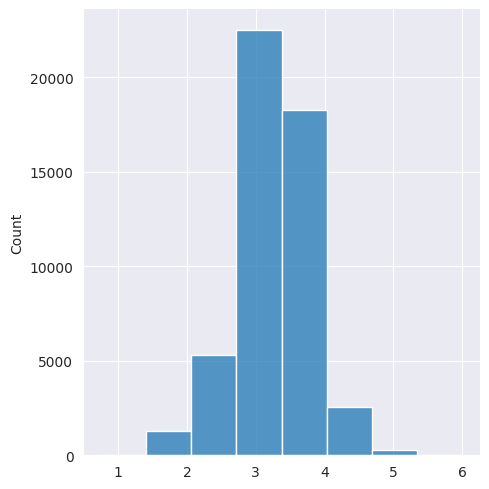

In [81]:
logits_diff = (outputs.logits - intervened_outputs.logits)[0, -2].to(torch.float32).cpu().detach().numpy()
sns.displot(logits_diff, bins=8)

##### Train Boundless DAS and Scanning through Layers!

Note that we are trying to find the alignment on the last token representation of the fifth (4 as 0-indexed) token! Please use our `run_tutorial.py` to train!

#### Analysis

Once you obtain interesting alignment results, you can start analyze them. Let's first load one interesting alignment we find using the alignment training script above.